# World Cup 2022 Predictions with Machine Learning
**Author**: [Justin Schubeck](https://www.linkedin.com/in/justinschubeck/) (jschubeck7@gmail.com)\
**Date**: November 15, 2022
---

## Setup

Importing necessary packages.

In [1]:
import numpy as np # 1.21.5
import pandas as pd # 1.3.5
import matplotlib.pyplot as plt # 3.5.1
import seaborn as sns # 0.11.2
# sklearn # 1.0.2
# scipy # 1.7.3
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from scipy import stats

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from operator import itemgetter

Import results of international soccer matches from 6/14/2018 (start of FIFA 2018 World Cup) to 9/27/2022 (final game before FIFA 2022 World Cup). 

In [2]:
games = pd.read_csv('results.csv')
games

,date,home_team,away_team,home_score,away_score,tournament
0,6/14/2018,Russia,Saudi Arabia,5,0,FIFA World Cup
1,6/15/2018,Egypt,Uruguay,0,1,FIFA World Cup
2,6/15/2018,Morocco,Iran,0,1,FIFA World Cup
3,6/15/2018,Portugal,Spain,3,3,FIFA World Cup
4,6/16/2018,France,Australia,2,1,FIFA World Cup
...,...,...,...,...,...,...
3617,9/27/2022,Albania,Iceland,1,1,UEFA Nations League
3618,9/27/2022,Norway,Serbia,0,2,UEFA Nations League
3619,9/27/2022,Sweden,Slovenia,1,1,UEFA Nations League
3620,9/27/2022,Kosovo,Cyprus,5,1,UEFA Nations League


Import FIFA International World Rankings from 6/7/2018 to 10/6/2022.

In [3]:
ranks = pd.read_csv('fifa_ranking.csv')
ranks

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,145,Afghanistan,AFG,188.00,199.00,5,AFC,6/7/2018
1,146,Afghanistan,AFG,1161.00,1161.00,0,AFC,7/1/2018
2,145,Afghanistan,AFG,1068.00,1068.00,0,AFC,8/16/2018
3,146,Afghanistan,AFG,1068.00,1068.00,1,AFC,9/20/2018
4,145,Afghanistan,AFG,1068.00,1068.00,-1,AFC,10/25/2018
...,...,...,...,...,...,...,...,...
7354,122,Zimbabwe,ZIM,1138.56,1138.44,1,CAF,2/10/2022
7355,122,Zimbabwe,ZIM,1138.56,1138.56,0,CAF,3/31/2022
7356,123,Zimbabwe,ZIM,1138.56,1138.56,1,CAF,6/23/2022
7357,123,Zimbabwe,ZIM,1138.56,1138.56,0,CAF,8/25/2022


---
## Data Cleaning

The date columns are changed to be in the datetime format.

In [4]:
games['date'] = pd.to_datetime(games['date'])
ranks['rank_date'] = pd.to_datetime(ranks['rank_date'])

Teams with different names in each dataset will be changed.

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)
ranks['country_full'] = ranks['country_full']\
                        .str.replace('IR Iran', 'Iran')\
                        .str.replace('Korea Republic', 'South Korea')\
                        .str.replace('USA', 'United States')\
                        .str.replace('Curacao', 'Curaçao')\
                        .str.replace('FYR Macedonia', 'North Macedonia')\
                        .str.replace('Cabo Verde', 'Cape Verde')\
                        .str.replace('Cape Verde Islands', 'Cape Verde')\
                        .str.replace('St. Vincent / Grenadines', 'Saint Vincent and the Grenadines')\
                        .str.replace('St. Vincent and the Grenadines', 'Saint Vincent and the Grenadines')\
                        .str.replace('Swaziland', 'Eswatini')\
                        .str.replace('Sao Tome e Principe', 'São Tomé and Príncipe')\
                        .str.replace('Türkiye', 'Turkey')\
                        .str.replace('Congo DR', 'DR Congo')\
                        .str.replace('Korea DPR', 'North Korea')\
                        .str.replace('Kyrgyz Republic', 'Kyrgyzstan')\
                        .str.replace('US Virgin Islands', 'United States Virgin Islands')\
                        .str.replace('Côte d\'Ivoire', 'Ivory Coast')\
                        .str.replace('St. Lucia', 'Saint Lucia')\
                        .str.replace('Chinese Taipei', 'Taiwan')\
                        .str.replace('St. Kitts and Nevis', 'Saint Kitts and Nevis')\
                        .str.replace('Brunei Darussalam', 'Brunei')

The rankings will be restrucutred to associate a country's ranking with each day.

In [6]:
ranks = ranks.set_index(['rank_date'])\
             .groupby(['country_full'], group_keys=False)\
             .resample('D')\
             .first()\
             .fillna(method='ffill')\
             .reset_index()

In [7]:
ranks

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
0,2018-06-07,145.0,Afghanistan,AFG,188.00,199.00,5.0,AFC
1,2018-06-08,145.0,Afghanistan,AFG,188.00,199.00,5.0,AFC
2,2018-06-09,145.0,Afghanistan,AFG,188.00,199.00,5.0,AFC
3,2018-06-10,145.0,Afghanistan,AFG,188.00,199.00,5.0,AFC
4,2018-06-11,145.0,Afghanistan,AFG,188.00,199.00,5.0,AFC
...,...,...,...,...,...,...,...,...
322927,2022-10-02,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
322928,2022-10-03,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
322929,2022-10-04,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
322930,2022-10-05,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF


The game results dataframe will append the FIFA ranking data to the right-most columns for the home team on each specific date while making sure to not add redundant columns.

In [8]:
df_wc_ranked = games.merge(ranks[['country_full', 
                                  'total_points', 
                                  'previous_points', 
                                  'rank', 
                                  'rank_change', 
                                  'rank_date']], 
                            left_on=['date', 
                                     'home_team'], 
                            right_on=['rank_date', 
                                      'country_full'])\
                    .drop(['rank_date', 'country_full'], 
                          axis=1)

In [9]:
df_wc_ranked

,date,home_team,away_team,home_score,away_score,tournament,total_points,previous_points,rank,rank_change
0,2018-06-14,Russia,Saudi Arabia,5,0,FIFA World Cup,457.00,493.00,70.0,4.0
1,2018-06-15,Egypt,Uruguay,0,1,FIFA World Cup,649.00,636.00,45.0,-1.0
2,2018-06-15,Morocco,Iran,0,1,FIFA World Cup,686.00,681.00,41.0,-1.0
3,2018-06-15,Portugal,Spain,3,3,FIFA World Cup,1274.00,1306.00,4.0,0.0
4,2018-06-16,France,Australia,2,1,FIFA World Cup,1198.00,1166.00,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3617,2022-09-27,Albania,Iceland,1,1,UEFA Nations League,1361.81,1361.81,66.0,0.0
3618,2022-09-27,Norway,Serbia,0,2,UEFA Nations League,1488.57,1488.57,36.0,0.0
3619,2022-09-27,Sweden,Slovenia,1,1,UEFA Nations League,1563.44,1563.44,20.0,0.0
3620,2022-09-27,Kosovo,Cyprus,5,1,UEFA Nations League,1183.90,1183.90,106.0,0.0


The game results dataframe will append the FIFA ranking data to the right-most columns for the away team for each specific date while making sure to not add redundant columns.

In [10]:
df_wc_ranked = df_wc_ranked.merge(ranks[['country_full', 
                                         'total_points', 
                                         'previous_points', 
                                         'rank', 
                                         'rank_change', 
                                         'rank_date']], 
                                  left_on=['date', 
                                           'away_team'], 
                                  right_on=['rank_date', 
                                            'country_full'], 
                                  suffixes=('_home', '_away'))\
                            .drop(['rank_date', 
                                   'country_full'], 
                                  axis=1)

In [11]:
df_wc_ranked

,date,home_team,away_team,home_score,away_score,tournament,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,2018-06-14,Russia,Saudi Arabia,5,0,FIFA World Cup,457.00,493.00,70.0,4.0,465.00,462.00,67.0,0.0
1,2018-06-15,Egypt,Uruguay,0,1,FIFA World Cup,649.00,636.00,45.0,-1.0,1018.00,976.00,14.0,-3.0
2,2018-06-15,Morocco,Iran,0,1,FIFA World Cup,686.00,681.00,41.0,-1.0,708.00,727.00,37.0,1.0
3,2018-06-15,Portugal,Spain,3,3,FIFA World Cup,1274.00,1306.00,4.0,0.0,1126.00,1162.00,10.0,2.0
4,2018-06-16,France,Australia,2,1,FIFA World Cup,1198.00,1166.00,7.0,0.0,718.00,700.00,36.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3617,2022-09-27,Albania,Iceland,1,1,UEFA Nations League,1361.81,1361.81,66.0,0.0,1379.61,1379.61,63.0,0.0
3618,2022-09-27,Norway,Serbia,0,2,UEFA Nations League,1488.57,1488.57,36.0,0.0,1549.53,1549.53,25.0,0.0
3619,2022-09-27,Sweden,Slovenia,1,1,UEFA Nations League,1563.44,1563.44,20.0,0.0,1372.48,1372.48,65.0,0.0
3620,2022-09-27,Kosovo,Cyprus,5,1,UEFA Nations League,1183.90,1183.90,106.0,0.0,1180.52,1180.52,108.0,1.0


Renaming dataframe post-cleaning.

In [12]:
df = df_wc_ranked

## Feature Engineering

New columns will be added to the dataframe to help create more features. \
\
**Columns:**
* *Result*
    * Type
        * 0 for home team win
        * 1 for away team win
        * 2 for draw
    * Home Team Points Gained
        * 3 for home team win
        * 0 for away team win
        * 1 for draw
    * Away Team Points Gained
        * 0 for home team win
        * 3 for away team win
        * 1 for draw
* *Difference In Rank*
    * Home Team Rank - Away Team Rank
* *Home Team Goal Difference*
    * Home Team Score - Away Team Score
* *Home Team Points Gained Per Opponent Rank*
    * Home Team Points Gained / Away Team Rank
* *Away Team Points Gained Per Opponent Rank*
    * Away Team Points Gained / Home Team Rank

Add *Result* columns.

In [13]:
def result_finder(home_goals_scored, away_goals_scored):
    if home_goals_scored > away_goals_scored:
        return pd.Series([0, 3, 0]) # home team win
    if home_goals_scored < away_goals_scored:
        return pd.Series([1, 0, 3]) # away team win
    else:
        return pd.Series([2, 1, 1]) # draw

results = df.apply(lambda x: result_finder(x["home_score"], 
                                           x["away_score"]), 
                                           axis=1)
df[["result", "home_team_points", "away_team_points"]] = results

Add *Difference in Rank* column.

In [14]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]

Add *Home Team Goal Difference* column.

In [15]:
df["goal_dif"] = df["home_score"] - df["away_score"]

Add *Home Team Points Gained Per Opponent Rank* column.

In [16]:
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]

Add *Away Team Points Gained Per Opponent Rank* column.

In [17]:
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In order to calculate more features, the home team data will be separated from the away team data.

In [18]:
home_team = df[["date", 
                "home_team", 
                "home_score", 
                "away_score", 
                "rank_home", 
                "rank_away",
                "rank_change_home",
                "total_points_home", 
                "result", 
                "rank_dif", 
                "points_home_by_rank", 
                "home_team_points"]]

away_team = df[["date", 
                "away_team", 
                "away_score", 
                "home_score", 
                "rank_away", 
                "rank_home",
                "rank_change_away", 
                "total_points_away", 
                "result", 
                "rank_dif", 
                "points_away_by_rank", 
                "away_team_points"]]

The *home* and *away* prefix and suffix will now be temporarily removed in order to generically generate more features. The *suf* previx and suffix is applied when refering to data of the opponent.

In [19]:
home_team.columns = [col.replace("home_", "")\
                     .replace("_home", "")\
                     .replace("away_", "suf_")\
                     .replace("_away", "_suf") \
                     for col in home_team.columns]

away_team.columns = [col.replace("away_", "")\
                     .replace("_away", "")\
                     .replace("home_", "suf_")\
                     .replace("_home", "_suf")\
                     for col in away_team.columns]

The data will now be combined into one large dataset to create features with ease specific to each team.

In [20]:
team_stats = home_team.append(away_team)

In [21]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2018-06-14,Russia,5,0,70.0,67.0,4.0,457.00,0,3.0,0.044776,3
1,2018-06-15,Egypt,0,1,45.0,14.0,-1.0,649.00,1,31.0,0.000000,0
2,2018-06-15,Morocco,0,1,41.0,37.0,-1.0,686.00,1,4.0,0.000000,0
3,2018-06-15,Portugal,3,3,4.0,10.0,0.0,1274.00,2,-6.0,0.100000,1
4,2018-06-16,France,2,1,7.0,36.0,0.0,1198.00,0,-29.0,0.083333,3
...,...,...,...,...,...,...,...,...,...,...,...,...
3617,2022-09-27,Iceland,1,1,63.0,66.0,0.0,1379.61,2,3.0,0.015152,1
3618,2022-09-27,Serbia,2,0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3
3619,2022-09-27,Slovenia,1,1,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1
3620,2022-09-27,Cyprus,1,5,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0


New features will be created to hopefully help predict results.
* Average goals scored.
* Average goals scored in last 5 games.
* Average goals scored in last 15 games.
* Average goals conceeded.
* Average goals conceeded in last 5 games.
* Average goals conceeded in last 15 games.
* Average FIFA Ranking of opponents.
* Average FIFA Ranking of opponents in last 5 games.
* Average FIFA Ranking of opponents in last 15 games.
* FIFA Ranking points won.
* FIFA Ranking points won in last 5 games.
* FIFA Ranking points won in last 15 games.
* Average points earned.
* Average points earned in last 5 games.
* Average points earned in last 15 games.
* Average points earned per opponent FIFA Ranking.
* Average points earned per opponent FIFA Ranking in last 5 games.
* Average points earned per opponent FIFA Ranking in last 15 games.

In [22]:
stats_val = []

for index, row in team_stats.iterrows():
    # Extract the team's name that this iteration is for.
    team = row["team"]
    
    # Extract the date of the specific game.
    date = row["date"]
    
    # Collect the data on all games for this team.
    past_games = team_stats.loc[(team_stats["team"] == team) & \
                                (team_stats["date"] < date)]\
                                .sort_values(by=['date'], 
                                             ascending=False)
    
    # Collect the data on the past 5 games.
    last5 = past_games.head(5)
    
    # Collect the data on the past 15 games.
    last15 = past_games.head(15)
    
    # Calculate the average goals scored.
    goals = past_games["score"].mean()
    
    # Calculate the average goals scored in last 5 games. 
    goals_l5 = last5["score"].mean()
    
    # Calculate the average goals scored in last 15 games. 
    goals_l15 = last15["score"].mean()
    
    # Calculate the average goals conceeded.
    goals_suf = past_games["suf_score"].mean()
    
    # Calculate the average goals conceeded in last 5 games. 
    goals_suf_l5 = last5["suf_score"].mean()
    
    # Calculate the average goals conceeded in last 5 games. 
    goals_suf_l15 = last15["suf_score"].mean()
    
    # Calculate the average FIFA ranking of opponent.
    rank = past_games["rank_suf"].mean()
    
    # Calculate the average FIFA ranking of opponent in last 5 games.
    rank_l5 = last5["rank_suf"].mean()
    
    # Calculate the average FIFA ranking of opponent in last 15 games.
    rank_l15 = last15["rank_suf"].mean()
    
    # If a team has played more than 1 game before this, calculate the change in:
    #    * FIFA Ranking points earned over the entire period.
    #    * FIFA Ranking points earned over the last 5 games.
    #    * FIFA Ranking points earned over the last 15 games.
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
        points_l15 = last15["total_points"].values[0] - last15["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        points_l15 = 0
        
    # Calculate the average points earned.
    gp = past_games["team_points"].mean()
    
    # Calculate the average points earned in last 5 games.
    gp_l5 = last5["team_points"].mean()
    
    # Calculate the average points earned in last 15 games.
    gp_l15 = last15["team_points"].mean()
    
    # Calculate the average points earned per opponent rank.
    gp_rank = past_games["points_by_rank"].mean()
    
    # Calculate the average points earned per opponent rank in last 5 games.
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    # Calculate the average points earned per opponent rank in last 15 games.
    gp_rank_l15 = last15["points_by_rank"].mean()
    
    # Add data to list for this iteration.
    stats_val.append([goals, 
                      goals_l5, 
                      goals_l15, 
                      goals_suf, 
                      goals_suf_l5, 
                      goals_suf_l15,
                      rank, 
                      rank_l5, 
                      rank_l15,
                      points, 
                      points_l5, 
                      points_l15, 
                      gp, 
                      gp_l5, 
                      gp_l15, 
                      gp_rank, 
                      gp_rank_l5,
                      gp_rank_l15])

The new feature data will be added to the individual team stats dataframe.

In [23]:
stats_cols = ["goals_mean", 
              "goals_mean_l5", 
              "goals_mean_l15", 
              "goals_suf_mean", 
              "goals_suf_mean_l5", 
              "goals_suf_mean_l15", 
              "rank_mean", 
              "rank_mean_l5", 
              "rank_mean_l15", 
              "points_mean",
              "points_mean_l5", 
              "points_mean_l15",
              "game_points_mean", 
              "game_points_mean_l5", 
              "game_points_mean_l15", 
              "game_points_rank_mean", 
              "game_points_rank_mean_l5",
              "game_points_rank_mean_l15"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], 
                    axis=1, 
                    ignore_index=False)

The dataframe will again be separated into home team and away team data.

In [24]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [25]:
home_team_stats = home_team_stats[home_team_stats.columns[-18:]]
away_team_stats = away_team_stats[away_team_stats.columns[-18:]]

The original *home* and *away* suffixes and prefixes will be added back onto the respective columns.

In [26]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

The home and away team data will be merged.

In [27]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], 
                        axis=1, 
                        ignore_index=False)

The new statistics calculated will be added onto the original match data.

In [28]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], 
                    axis=1, 
                    ignore_index=False)

A new column will be added indicating if the game was friendly (0), semi-competitive (1), or competitive (2).

In [29]:
def find_friendly(x):
    competitives = ['AFC Asian Cup',
                    'AFC Asian Cup qualification', 
                    'African Cup of Nations',
                    'African Cup of Nations qualification',
                    'African Nations Championship qualification', 
                    'CONCACAF Nations League',
                    'CONCACAF Nations League qualification',
                    'Copa América',
                    'FIFA World Cup',
                    'FIFA World Cup qualification', 
                    'Gold Cup',
                    'Gold Cup qualification', 
                    'UEFA Euro', 
                    'UEFA Euro qualification',
                    'UEFA Nations League']
    
    if x == "Friendly":
        return 0
    elif x in competitives: 
        return 2
    else:
        return 1

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

The new added column indicating the type of match will be turned into one-hot-encoding. 

In [30]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [31]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'total_points_home', 'previous_points_home', 'rank_home',
       'rank_change_home', 'total_points_away', 'previous_points_away',
       'rank_away', 'rank_change_away', 'result', 'home_team_points',
       'away_team_points', 'rank_dif', 'goal_dif', 'points_home_by_rank',
       'points_away_by_rank', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_mean_l15', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_goals_suf_mean_l15', 'home_rank_mean', 'home_rank_mean_l5',
       'home_rank_mean_l15', 'home_points_mean', 'home_points_mean_l5',
       'home_points_mean_l15', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_mean_l15',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5',
       'home_game_points_rank_mean_l15', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_mean_l15', 'away_goals_suf_mean',
       'away_goa

The columns that will help in feature analysis will be extracted from the full dataframe.

In [32]:
base_df = full_df[[
   "date", 
   "home_team", "away_team", 
   "rank_home", "rank_away",
   "home_score", "away_score", "result", 
   "rank_dif", "rank_change_home", "rank_change_away", 

   'home_goals_mean', 'home_goals_mean_l5', 'home_goals_mean_l15',
   'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_goals_suf_mean_l15',
   'home_rank_mean', 'home_rank_mean_l5',  'home_rank_mean_l15', 
   'home_points_mean', 'home_points_mean_l5', 'home_points_mean_l15', 
   'away_goals_mean', 'away_goals_mean_l5', 'away_goals_mean_l15',
   'away_goals_suf_mean', 'away_goals_suf_mean_l5',  'away_goals_suf_mean_l15', 
   'away_rank_mean', 'away_rank_mean_l5',  'away_rank_mean_l15', 
   'away_points_mean', 'away_points_mean_l5', 'away_points_mean_l15',
   'home_game_points_mean', 'home_game_points_mean_l5', 'home_game_points_mean_l15',
   'home_game_points_rank_mean', 'home_game_points_rank_mean_l5', 'home_game_points_rank_mean_l15',
   'away_game_points_mean', 'away_game_points_mean_l5',  'away_game_points_mean_l15', 
   'away_game_points_rank_mean', 'away_game_points_rank_mean_l5', 'away_game_points_rank_mean_l15',
   'is_friendly_0', 'is_friendly_1', 'is_friendly_2']]

The NA data where previous 5 or 15 games could not be calculated will be dropped.

In [33]:
base_df_no_fg = base_df.dropna()

---
## Feature Analysis
The features will be analysed to see how well they predict.

In [34]:
df = base_df_no_fg

The result must be binary to compare if the features separate classes well. In this case, a draw for the home team will be counted as a loss (1), and a home team win will still be a win (0).

In [35]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

C:\Users\jts1s\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


The data will be split into three groups for visualization purposes only.

In [36]:
data1 = df[list(df.columns[8:22].values) + ["target"]]
data2 = df[list(df.columns[22:36].values) + ["target"]]
data3 = df[df.columns[36:]]

The data will be standardized and then plotted on a violin plot.

In [37]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data3[:-1] - data3[:-1].mean()) / data3[:-1].std()
scaled["target"] = data3["target"]
violin3 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

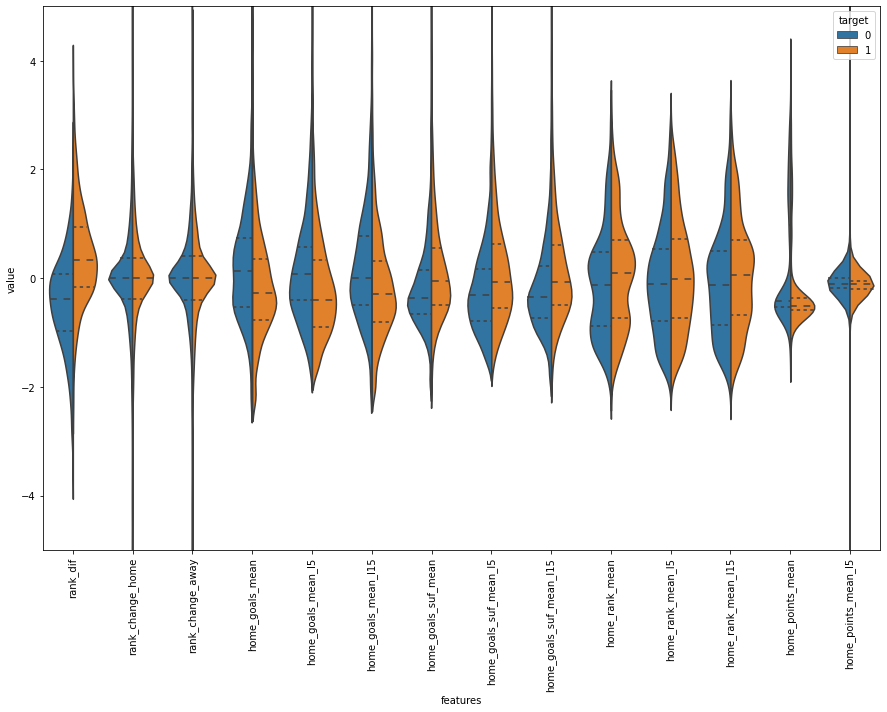

In [38]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.ylim([-5, 5]) # Uncomment to zoom in.
plt.show()

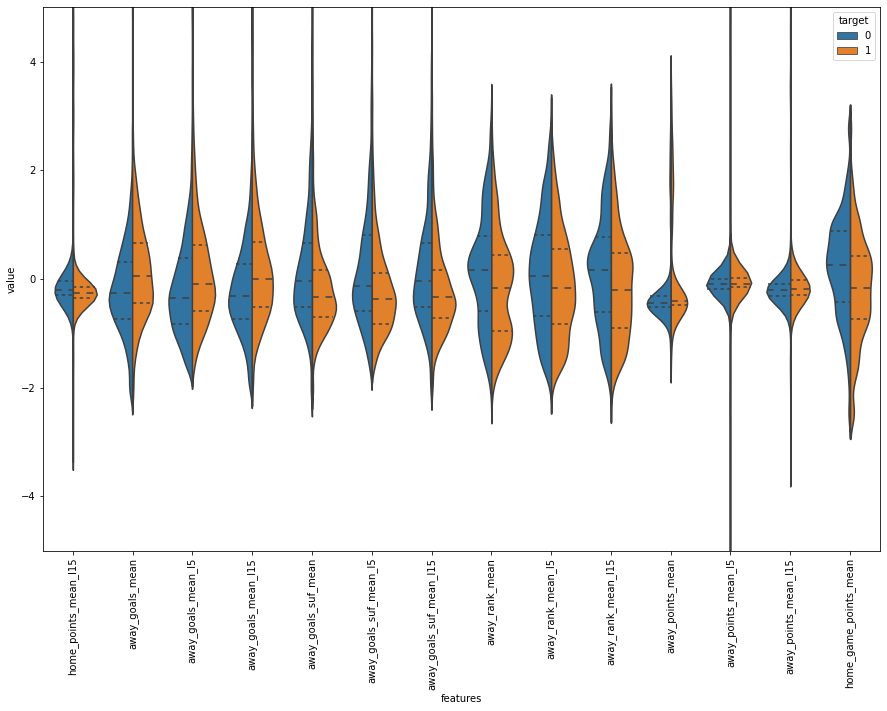

In [39]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.ylim([-5, 5]) # Uncomment to zoom in.
plt.show()

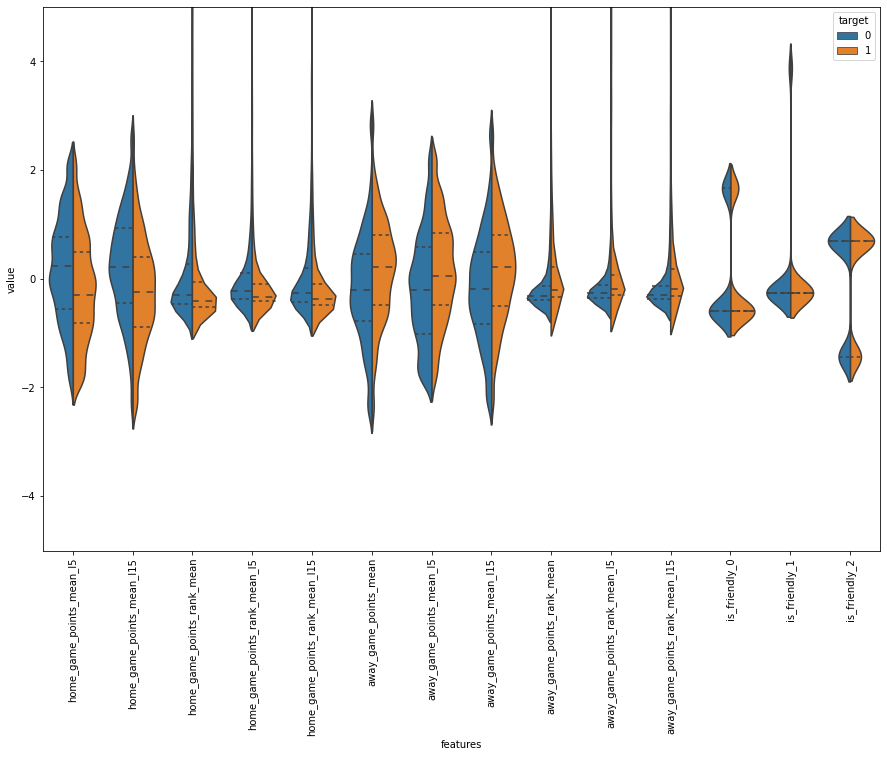

In [40]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin3,split=True, inner="quart")
plt.xticks(rotation=90)
plt.ylim([-5, 5]) # Uncomment to zoom in.
plt.show()

```rank_dif``` was the only real feature where it looks like the labels are clearly separable. However, more features can still be calculated to test out.

In [41]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_dif_l15"] = dif["home_goals_mean_l15"] - dif["away_goals_mean_l15"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_dif_l15"] = dif["home_goals_suf_mean_l15"] - dif["away_goals_suf_mean_l15"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif_l15"] = dif["home_goals_mean_l15"] - dif["away_goals_suf_mean_l15"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_made_dif_l15"] = dif["home_goals_suf_mean_l15"] - dif["away_goals_mean_l15"]

The new feature data will be scaled and violin plots analyzed.

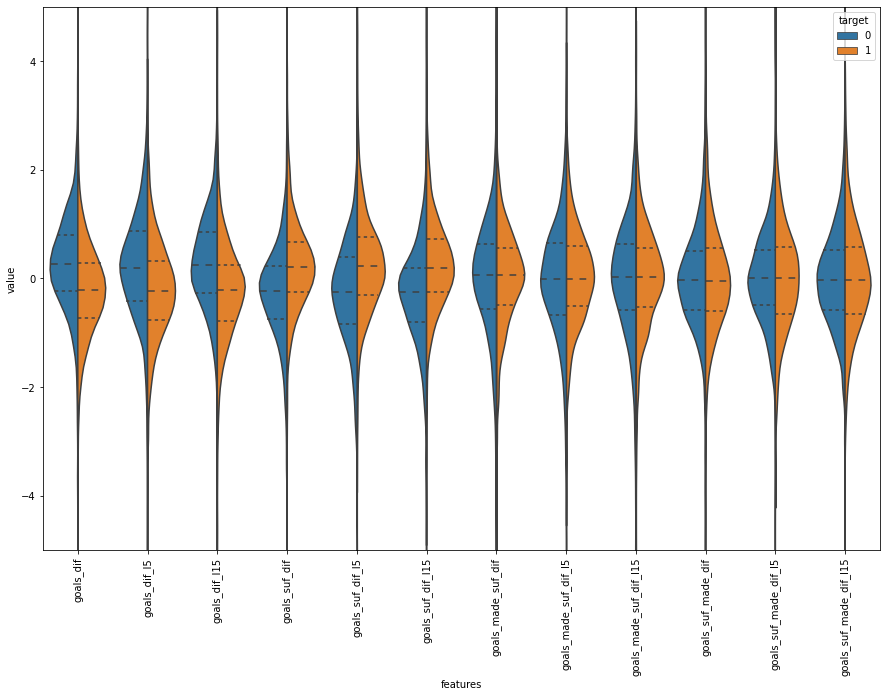

In [42]:
data_difs = dif.iloc[:, -12:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = df["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.ylim([-5, 5]) # Uncomment to zoom in.
plt.show()

Goal differences and goals suffered differences look to be good separators too. 

The 7 good features found are:
* ```rank_dif```
* ```goals_dif```
* ```goals_dif_l5```
* ```goals_dif_l15```
* ```goals_suf_dif```
* ```goals_suf_dif_l5```
* ```goals_suf_dif_l15```

Some more features will be tested and analyzed.

In [43]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_l15"] = dif["home_game_points_mean_l15"] - dif["away_game_points_mean_l15"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]
dif.loc[:, "dif_points_rank_l15"] = dif["home_game_points_rank_mean_l15"] - dif["away_game_points_rank_mean_l15"]
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]
dif.loc[:, "dif_rank_agst_l15"] = dif["home_rank_mean_l15"] - dif["away_rank_mean_l15"]
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean_l5"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean_l5"])
dif.loc[:, "goals_per_ranking_dif_l15"] = (dif["home_goals_mean_l15"] / dif["home_rank_mean_l15"]) - (dif["away_goals_mean_l15"] / dif["away_rank_mean_l15"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean_l5"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean_l5"])
dif.loc[:, "goals_per_ranking_suf_dif_l15"] = (dif["home_goals_suf_mean_l15"] / dif["home_rank_mean_l15"]) - (dif["away_goals_suf_mean_l15"] / dif["away_rank_mean_l15"])

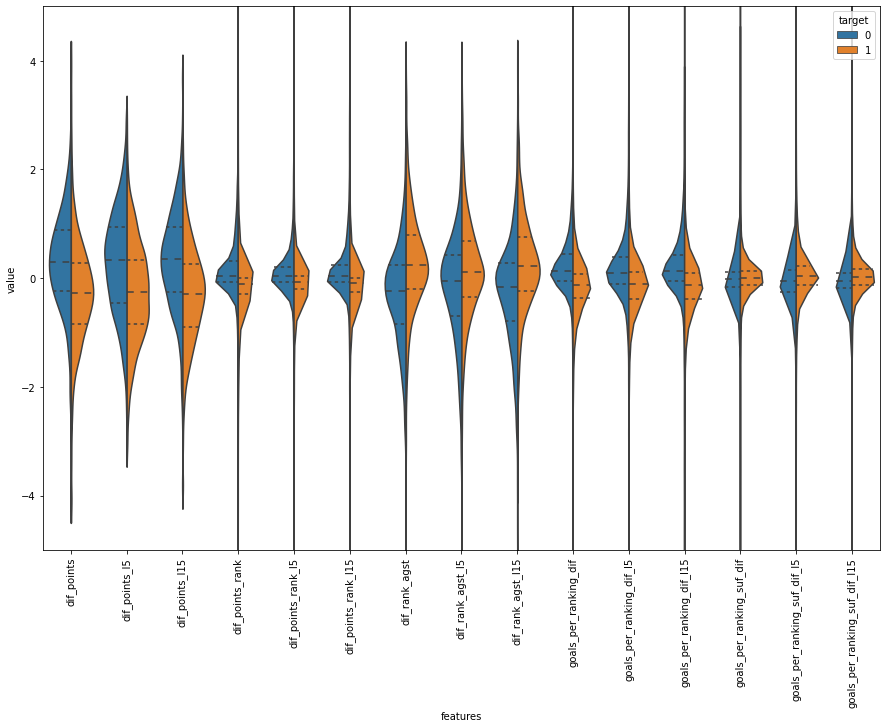

In [44]:
data_difs = dif.iloc[:, -15:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = df["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.ylim([-5, 5]) # Uncomment to zoom in.
plt.show()

The difference in points, difference of points by opponent ranking, difference of opponents ranking, and goals per opponent ranking difference seem to separate the data well.

To ensure semi-duplicate distributions of features are not used, some will be compared. 

**Difference in mean points.**

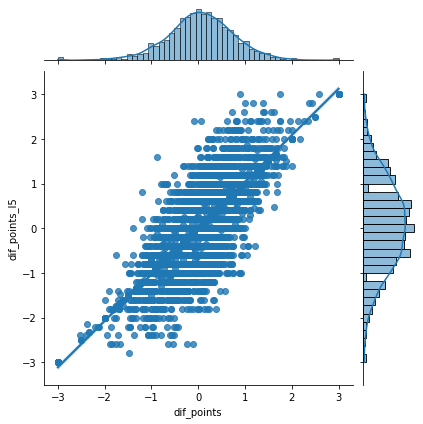

In [45]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

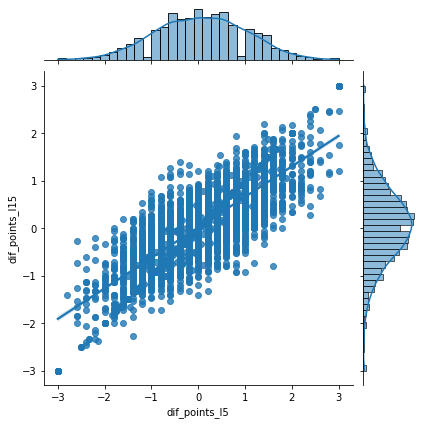

In [46]:
sns.jointplot(data = data_difs, x = 'dif_points_l5', y = 'dif_points_l15', kind="reg")
plt.show()

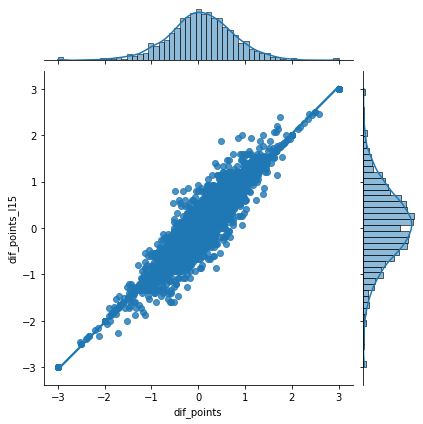

In [47]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l15', kind="reg")
plt.show()

**Difference in mean points by opponent's rank.**

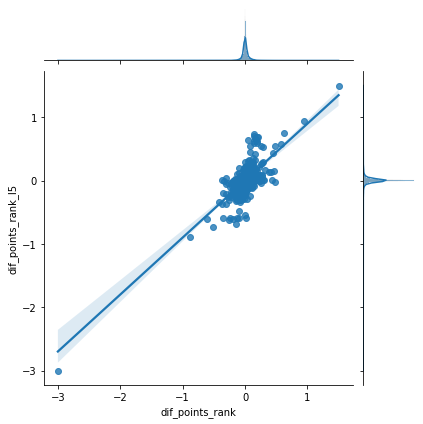

In [48]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

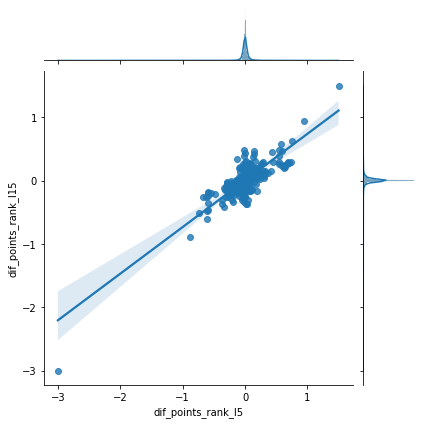

In [49]:
sns.jointplot(data = data_difs, x = 'dif_points_rank_l5', y = 'dif_points_rank_l15', kind="reg")
plt.show()

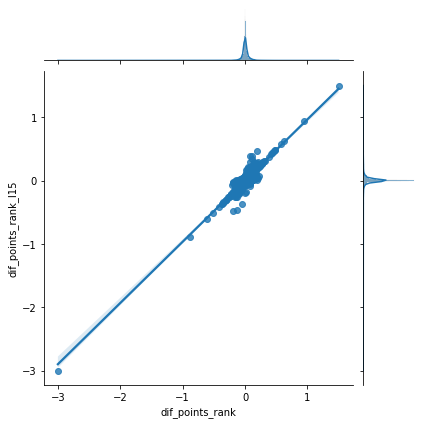

In [50]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l15', kind="reg")
plt.show()

**Difference in mean rank of opponents.**

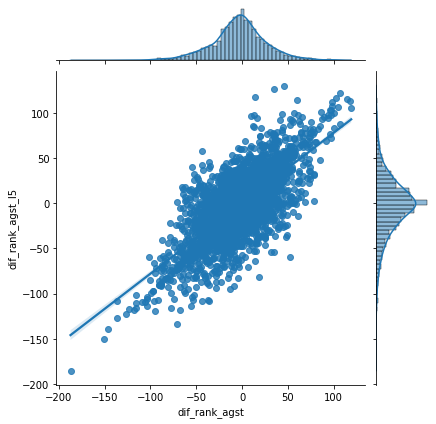

In [51]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

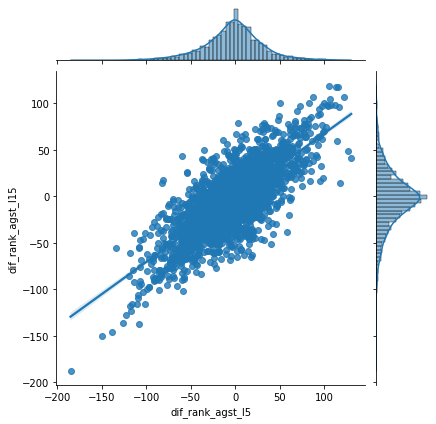

In [52]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst_l5', y = 'dif_rank_agst_l15', kind="reg")
plt.show()

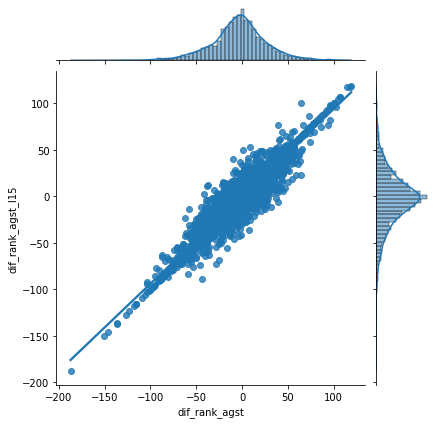

In [53]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l15', kind="reg")
plt.show()

**Difference in goals per opponent mean rank.**

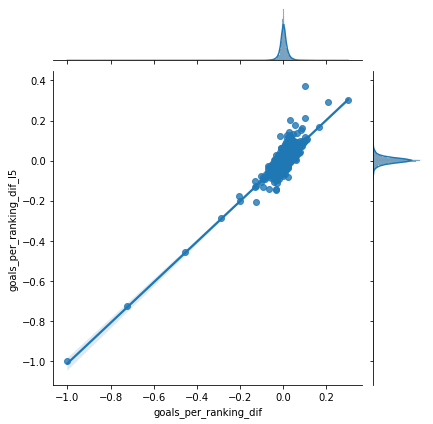

In [54]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

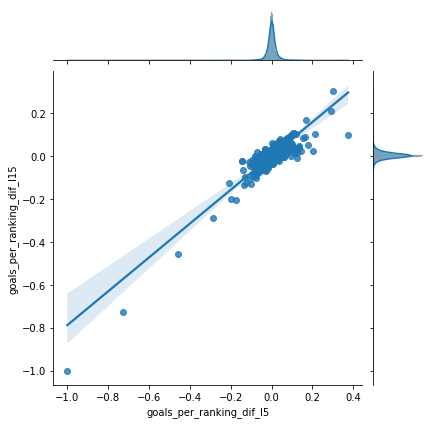

In [55]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif_l5', y = 'goals_per_ranking_dif_l15', kind="reg")
plt.show()

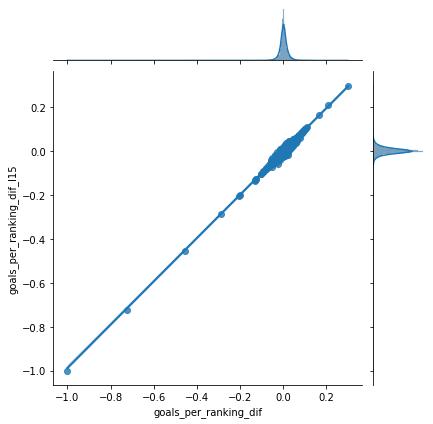

In [56]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l15', kind="reg")
plt.show()

**Difference in goals suffered per opponent mean rank.**

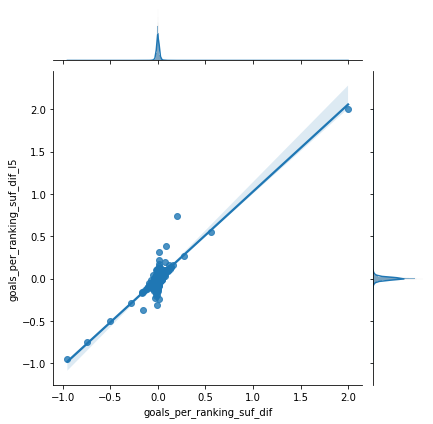

In [57]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_suf_dif', y = 'goals_per_ranking_suf_dif_l5', kind="reg")
plt.show()

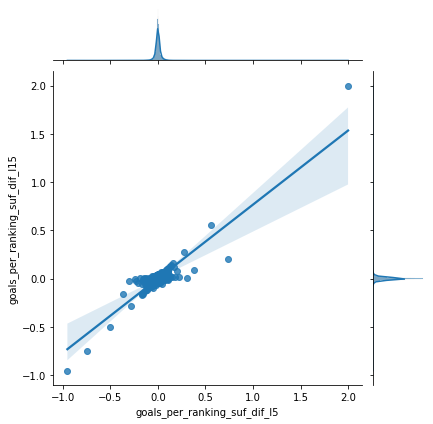

In [58]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_suf_dif_l5', y = 'goals_per_ranking_suf_dif_l15', kind="reg")
plt.show()

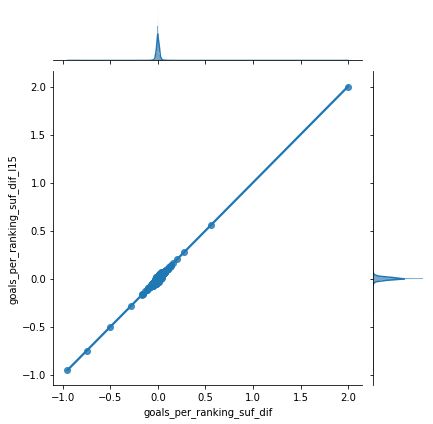

In [59]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_suf_dif', y = 'goals_per_ranking_suf_dif_l15', kind="reg")
plt.show()

The final features will now be:
* ```rank_dif```
* ```goals_dif```
* ```goals_dif_l5```
* ```goals_dif_l15```
* ```goals_suf_dif```
* ```goals_suf_dif_l5```
* ```goals_suf_dif_l15```
* ```dif_points```
* ```dif_points_l5```
* ```dif_points_rank```
* ```dif_points_rank_l5```
* ```goals_per_ranking_dif```
* ```dif_rank_agst```
* ```dif_rank_agst_l5```
* ```is_friendly```

The following function will create the final dataframe for the model input based upon the needed columns and selected features. 

In [60]:
def create_df(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "away_goals_mean",
               "home_rank_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", 
               "home_game_points_mean", "home_game_points_mean_l5",  
               "away_game_points_mean", "away_game_points_mean_l5",  
               "home_rank_mean_l15", "away_rank_mean_l15",
               "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", 
               "home_goals_mean_l15", "away_goals_mean_l15", 
               "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", 
               "home_goals_suf_mean_l15", "away_goals_suf_mean_l15", 
               "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "home_game_points_rank_mean_l15", 
               "away_game_points_rank_mean", "away_game_points_rank_mean_l5", "away_game_points_rank_mean_l15",
               "is_friendly_0", "is_friendly_1", "is_friendly_2"]
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_dif_l15"] = base["home_goals_mean_l15"] - base["away_goals_mean_l15"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_suf_dif_l15"] = base["home_goals_suf_mean_l15"] - base["away_goals_suf_mean_l15"]
    base.loc[:, "dif_points"] = base["home_game_points_mean"] - base["away_game_points_mean"]
    base.loc[:, "dif_points_l5"] = base["home_game_points_mean_l5"] - base["away_game_points_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_dif_l15", 
                     "goals_suf_dif", "goals_suf_dif_l5", "goals_suf_dif_l15", "dif_points", "dif_points_l5",
                     "dif_points_rank", "dif_points_rank_l5", "goals_per_ranking_dif", "dif_rank_agst", 
                     "dif_rank_agst_l5",  "is_friendly_0", "is_friendly_1", "is_friendly_2"]]
    return model_df

The final dataframe for the model will now be created.

In [61]:
model_df = create_df(df)
model_df

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_dif_l15,goals_suf_dif,goals_suf_dif_l5,goals_suf_dif_l15,dif_points,dif_points_l5,dif_points_rank,dif_points_rank_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,is_friendly_0,is_friendly_1,is_friendly_2
16,Russia,Egypt,0,25.0,5.000000,5.0,5.000000,-1.000000,-1.0,-1.000000,3.000000,3.0,0.044776,0.044776,0.074627,53.000000,53.0,0,0,1
17,Portugal,Morocco,0,-37.0,3.000000,3.0,3.000000,2.000000,2.0,2.000000,1.000000,1.0,0.100000,0.100000,0.300000,-27.000000,-27.0,0,0,1
18,Uruguay,Saudi Arabia,0,-53.0,1.000000,1.0,1.000000,-5.000000,-5.0,-5.000000,3.000000,3.0,0.066667,0.066667,0.022222,-25.000000,-25.0,0,0,1
19,Iran,Spain,1,27.0,-2.000000,-2.0,-2.000000,-3.000000,-3.0,-3.000000,2.000000,2.0,-0.176829,-0.176829,-0.725610,37.000000,37.0,0,0,1
20,Denmark,Australia,1,-24.0,0.000000,0.0,0.000000,-2.000000,-2.0,-2.000000,3.000000,3.0,0.272727,0.272727,-0.051948,4.000000,4.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3617,Albania,Iceland,1,3.0,0.022089,-0.8,-0.266667,-0.578463,0.0,-0.466667,0.290382,-1.2,-0.017882,-0.014533,-0.005293,23.575702,-14.8,0,0,1
3618,Norway,Serbia,1,11.0,0.032738,-0.8,-0.066667,-0.244048,0.0,-0.066667,0.020833,0.0,-0.010727,0.016348,-0.005675,11.776786,-3.4,0,0,1
3619,Sweden,Slovenia,1,-45.0,0.020764,0.2,-0.333333,0.107143,0.2,0.133333,0.229651,-0.4,0.029638,-0.020314,0.010869,-27.982558,10.2,0,0,1
3620,Kosovo,Cyprus,0,-2.0,0.667341,0.6,0.600000,-0.463094,0.0,-0.800000,0.558645,0.2,0.008791,-0.002827,0.007625,7.037917,1.6,0,0,1


---
# Classifier Models: Random Forest & Gradient Boosting

The input data and targets for the model will be extracted.

In [62]:
X = model_df.iloc[:, 3:]
labels = np.squeeze(model_df[["target"]].to_numpy())

The type of competition will be the stratifying parameter.

In [63]:
strat = np.empty([len(labels)])
strat[X['is_friendly_0']==1]=0
strat[X['is_friendly_1']==1]=1
strat[X['is_friendly_2']==1]=2

The model will be split into a 80%-to-20% train-test-split.

In [64]:
X_train, X_test, t_train, t_test = train_test_split(X, 
                                                    labels, 
                                                    test_size= 0.2, 
                                                    random_state=1,
                                                    stratify=strat)

The data will now be standardized for numeric columns.

In [65]:
scale_pipe = ColumnTransformer([('scale', StandardScaler(), list(range(0,14)))],
                               remainder='passthrough')
X_train_scaled = scale_pipe.fit_transform(X_train.values)
X_test_scaled = scale_pipe.transform(X_test.values)
X_train = X_train_scaled
X_test = X_test_scaled

### Gradient Boosting

In [66]:
%%time
gb = GradientBoostingClassifier(random_state=7)

params = {"learning_rate": [0.001, 0.01, 0.1, 0.5],
          "min_samples_split": [3, 5, 10],
          "min_samples_leaf": [3, 5, 7],
          "max_depth":[3,5,10],
          "max_features":["sqrt"],
          "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, 
                     params, 
                     cv=3, 
                     n_jobs=-1)

# gb_cv.fit(X_train.values, np.ravel(t_train))
gb_cv.fit(X_train, t_train)
gb = gb_cv.best_estimator_

# 95% confidence interval
scores = cross_val_score(gb, 
                         X_train, 
                         t_train,
                         scoring='accuracy',
                         cv=5)
print(stats.t.interval(0.95,
      len(scores)-1,
      loc = scores.mean(),
      scale=scores.std(ddof=1)/np.sqrt(len(scores))))
gb

(0.6682883037807136, 0.7336704743638524)
Wall time: 1min 56s


GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=7, min_samples_split=3,
                           random_state=7)

### Random Forest

In [67]:
%%time
rf = RandomForestClassifier(random_state=7)

params_rf = {"max_depth": [5, 10, 20],
             "min_samples_split": [2, 3, 4, 5, 10],
             "max_leaf_nodes": [150, 175],
             "min_samples_leaf": [5, 10, 15],
             "n_estimators": [150, 250, 500],
             "max_features": ["sqrt"],
            }

rf_cv = GridSearchCV(rf, 
                     params_rf, 
                     cv=3,
                     n_jobs=-1)

# rf_cv.fit(X_train.values, np.ravel(t_train))
rf_cv.fit(X_train, np.ravel(t_train))
rf = rf_cv.best_estimator_

# 95% confidence interval
scores = cross_val_score(rf, 
                         X_train, 
                         t_train,
                         scoring='accuracy',
                         cv=5)
print(stats.t.interval(0.95,
      len(scores)-1,
      loc = scores.mean(),
      scale=scores.std(ddof=1)/np.sqrt(len(scores))))
rf

(0.6677231083331896, 0.7220428550008515)
Wall time: 3min 45s


RandomForestClassifier(max_depth=5, max_features='sqrt', max_leaf_nodes=150,
                       min_samples_leaf=10, n_estimators=150, random_state=7)

### Support Vector Machine

In [68]:
%%time
svm = SVC(random_state=7)

params_svm = {"C": np.logspace(-2,2,5),
              "kernel": ['rbf'],
              "gamma": list(np.logspace(-2,2,5))+['scale','auto'],
              "probability": [True]
            }

svm_cv = GridSearchCV(svm, 
                      params_svm, 
                      cv=3,
                      n_jobs=-1)

# svm_cv.fit(X_train.values, np.ravel(t_train))
svm_cv.fit(X_train, np.ravel(t_train))
svm = svm_cv.best_estimator_

# 95% confidence interval
scores = cross_val_score(svm, 
                         X_train, 
                         t_train,
                         scoring='accuracy',
                         cv=5)
print(stats.t.interval(0.95,
      len(scores)-1,
      loc = scores.mean(),
      scale=scores.std(ddof=1)/np.sqrt(len(scores))))
svm

(0.6661863143560298, 0.7300364097870049)
Wall time: 1min


SVC(gamma=0.01, probability=True, random_state=7)

### Logistic Regression

In [69]:
%%time
lr = LogisticRegression(random_state=7)

params_lr = {"C": np.logspace(-2,2,5),
             "penalty": ['l2'],
             "solver": ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
             "max_iter": [2000]
            }

lr_cv = GridSearchCV(lr, 
                     params_lr, 
                     cv=3,
                     n_jobs=-1)

# lr_cv.fit(X_train.values, np.ravel(t_train))
lr_cv.fit(X_train, np.ravel(t_train))
lr = lr_cv.best_estimator_

# 95% confidence interval
scores = cross_val_score(lr, 
                         X_train, 
                         t_train,
                         scoring='accuracy',
                         cv=5)
print(stats.t.interval(0.95,
      len(scores)-1,
      loc = scores.mean(),
      scale=scores.std(ddof=1)/np.sqrt(len(scores))))
lr

(0.6633649326334179, 0.7400301112203043)
Wall time: 1.57 s


LogisticRegression(C=0.01, max_iter=2000, random_state=7, solver='saga')

## Analysis of Models

In [70]:
def analyze(model):
#     fpr, tpr, _ = roc_curve(t_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    fpr, tpr, _ = roc_curve(t_test, model.predict_proba(X_test)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

#     fpr_train, tpr_train, _ = roc_curve(t_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    fpr_train, tpr_train, _ = roc_curve(t_train, model.predict_proba(X_train)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
#     auc_test = roc_auc_score(t_test, model.predict_proba(X_test.values)[:,1])
    auc_test = roc_auc_score(t_test, model.predict_proba(X_test)[:,1])
#     auc_train = roc_auc_score(t_train, model.predict_proba(X_train.values)[:,1])
    auc_train = roc_auc_score(t_train, model.predict_proba(X_train)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
#     cm = confusion_matrix(t_test, model.predict(X_test.values))
    cm = confusion_matrix(t_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d")

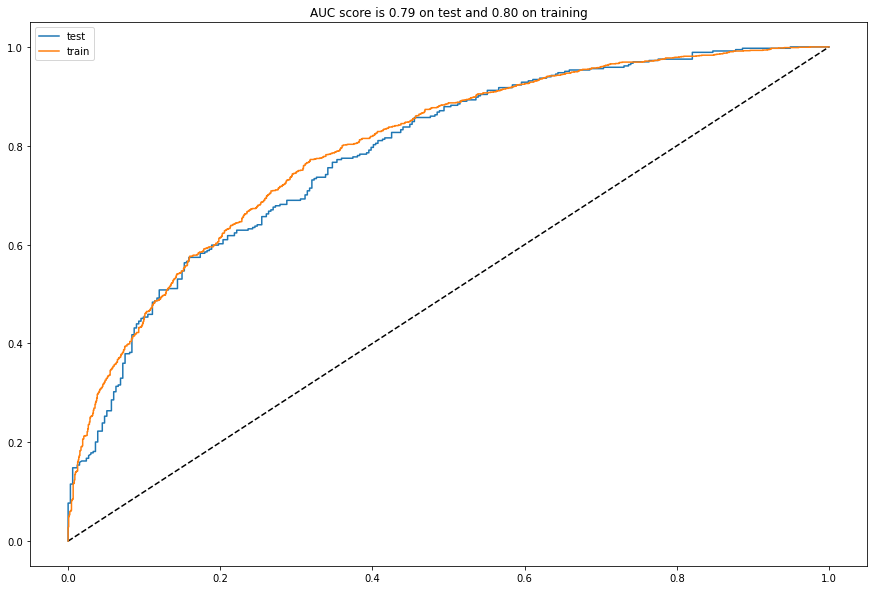

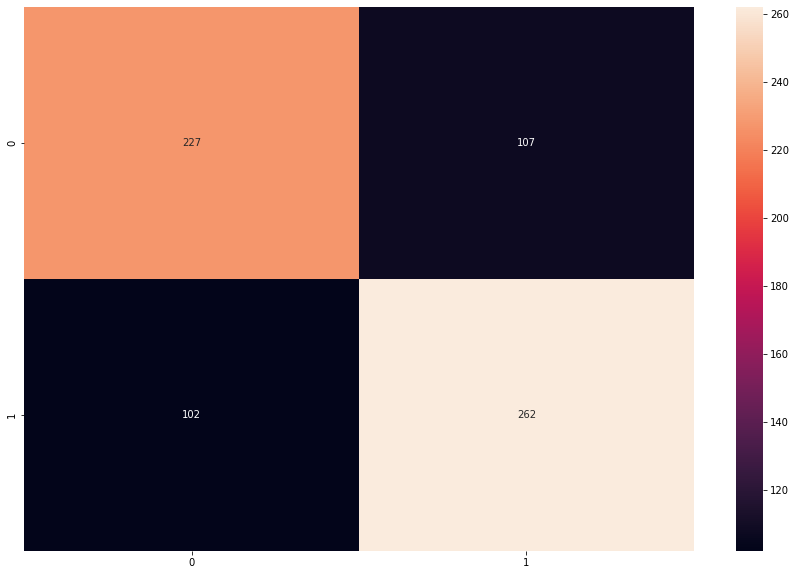

In [71]:
analyze(gb)

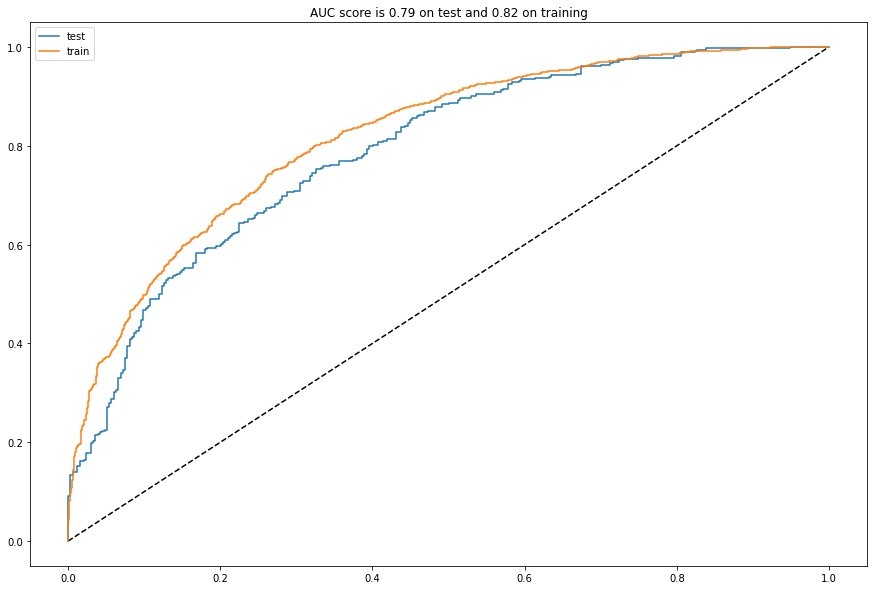

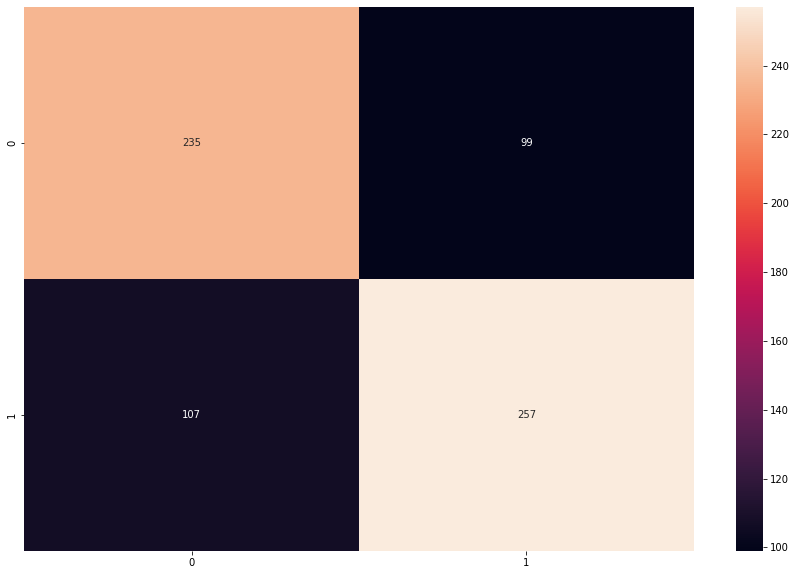

In [72]:
analyze(rf)

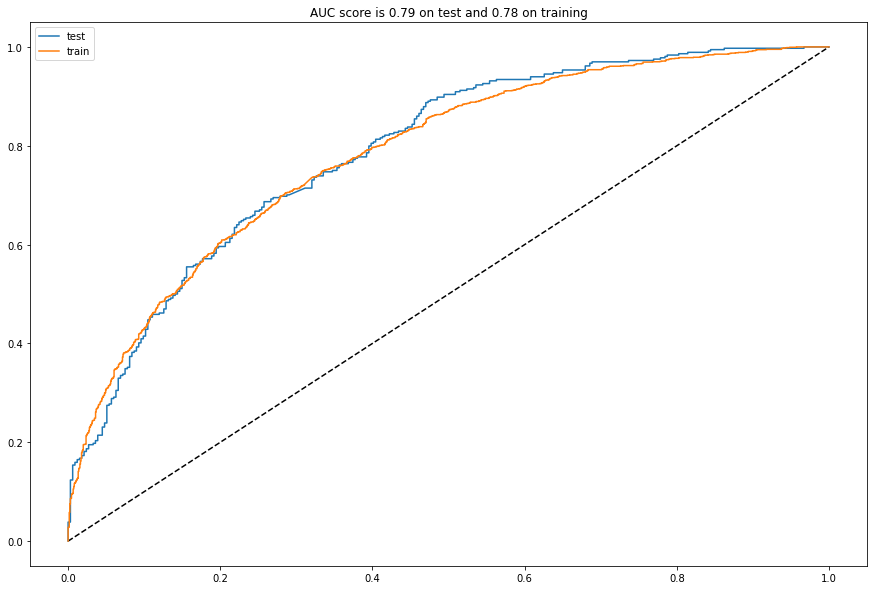

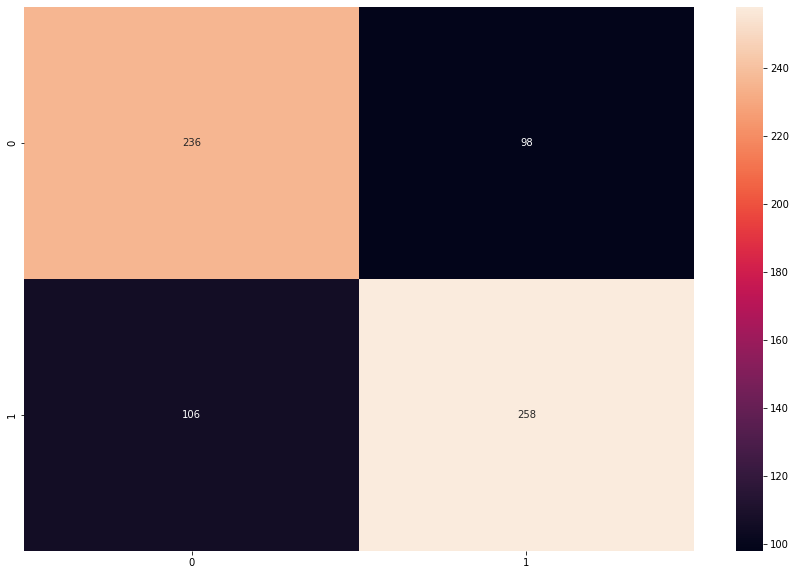

In [73]:
analyze(svm)

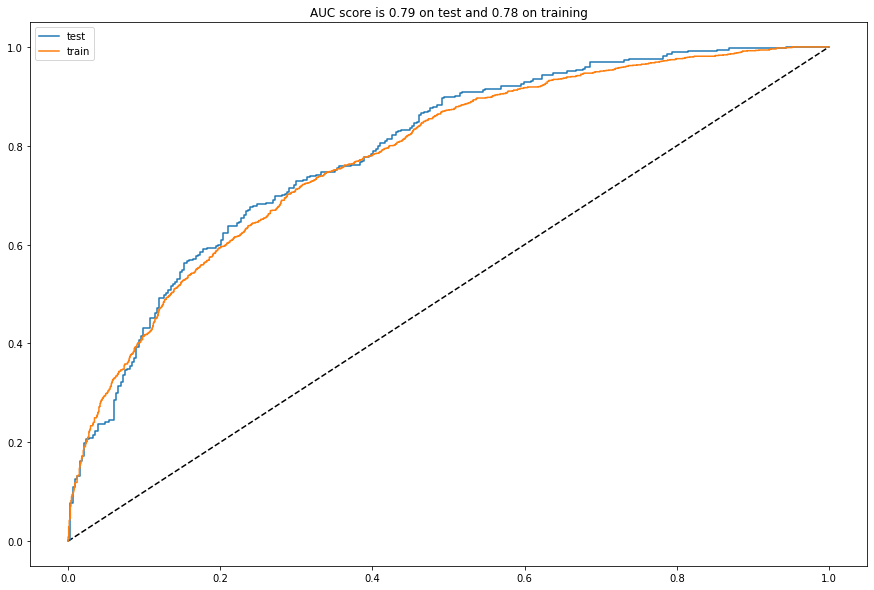

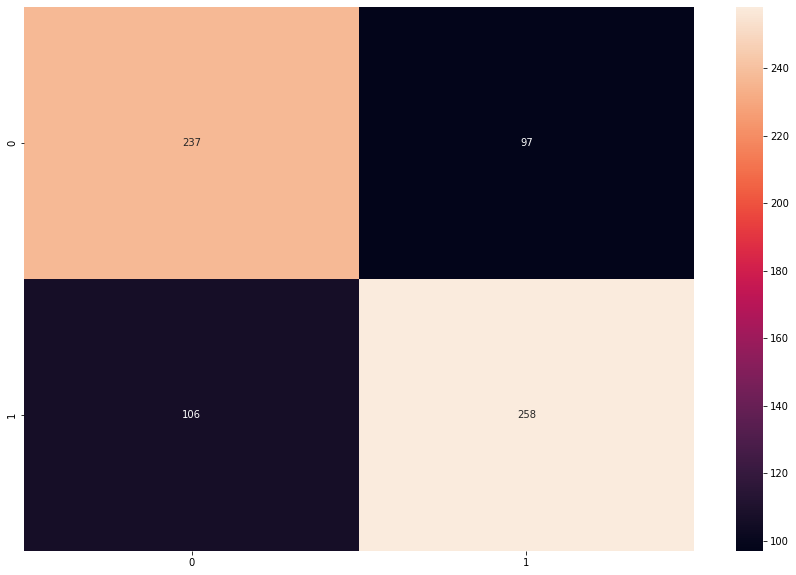

In [74]:
analyze(lr)

---
# World Cup 2022

The final model will be trained here on all the data to predict the 2022 World Cup.

In [75]:
gb = GradientBoostingClassifier(learning_rate=0.01, 
                                max_features='sqrt',
                                min_samples_leaf=7, 
                                min_samples_split=3,
                                random_state=7)
gb.fit(scale_pipe.fit_transform(X.values), labels)

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=7, min_samples_split=3,
                           random_state=7)

In [76]:
rf = RandomForestClassifier(max_depth=5, 
                            max_features='sqrt', 
                            max_leaf_nodes=150,
                            min_samples_leaf=10, 
                            n_estimators=150, 
                            random_state=7)
rf.fit(scale_pipe.fit_transform(X.values), labels)

RandomForestClassifier(max_depth=5, max_features='sqrt', max_leaf_nodes=150,
                       min_samples_leaf=10, n_estimators=150, random_state=7)

In [77]:
svm = SVC(gamma=0.01, 
          probability=True, 
          random_state=7)
svm.fit(scale_pipe.fit_transform(X.values), labels)

SVC(gamma=0.01, probability=True, random_state=7)

In [78]:
lr = LogisticRegression(C=0.01, 
                        max_iter=2000,
                        random_state=7, 
                        solver='saga')
lr.fit(scale_pipe.fit_transform(X.values), labels)

LogisticRegression(C=0.01, max_iter=2000, random_state=7, solver='saga')

**CHOOSE THE FINAL MODEL HERE!**

In [79]:
final_model = gb

The World Cup 2022 groups will be created.

In [80]:
#TABLE -> TEAM, POINTS, WIN PROBABILITIES (TIEBREAKER)
table = {'A': [['Qatar', 0, []],
               ['Ecuador', 0, []],
               ['Senegal', 0, []],
               ['Netherlands', 0, []]],
         'B': [['England', 0, []],
               ['Iran', 0, []],
               ['United States', 0, []],
               ['Wales', 0, []]],
         'C': [['Argentina', 0, []],
               ['Saudi Arabia', 0, []],
               ['Mexico', 0, []],
               ['Poland', 0, []]],
         'D': [['France', 0, []],
               ['Australia', 0, []],
               ['Denmark', 0, []],
               ['Tunisia', 0, []]],
         'E': [['Spain', 0, []],
               ['Costa Rica', 0, []],
               ['Germany', 0, []],
               ['Japan', 0, []]],
         'F': [['Belgium', 0, []],
               ['Canada', 0, []],
               ['Morocco', 0, []],
               ['Croatia', 0, []]],
         'G': [['Brazil', 0, []],
               ['Serbia', 0, []],
               ['Switzerland', 0, []],
               ['Cameroon', 0, []]],
         'H': [['Portugal', 0, []],
               ['Ghana', 0, []],
               ['Uruguay', 0, []],
               ['South Korea', 0, []]]}

A list of group stage matches will be created.

In [81]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

for i in range(13, 68, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1

In [82]:
matches

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States'),
 ('B', 'Wales', 'England'),
 ('B', 'Iran', 'United States'),
 ('C', 'Argentina', 'Saudi Arabia'),
 ('C', 'Mexico', 'Poland'),
 ('C', 'Poland', 'Saudi Arabia'),
 ('C', 'Argentina', 'Mexico'),
 ('C', 'Poland', 'Argentina'),
 ('C', 'Saudi Arabia', 'Mexico'),
 ('D', 'Denmark', 'Tunisia'),
 ('D', 'France', 'Australia'),
 ('D', 'Tunisia', 'Australia'),
 ('D', 'France', 'Denmark'),
 ('D', 'Australia', 'Denmark'),
 ('D', 'Tunisia', 'France'),
 ('E', 'Germany', 'Japan'),
 ('E', 'Spain', 'Costa Rica'),
 ('E', 'Japan', 'Costa Rica'),
 ('E', 'Spain', 'Germany'),
 ('E', 'Japan', 'Spain'),
 ('E', 'Costa Rica', 'Germany'),
 ('F', 'Morocco', 'Croatia'),
 ('F', 'Belgium', 'Canada'),
 ('F', 'Belgium',

The stats for each team to predict how they will do against their opponent will have to be generated.

In [83]:
team_stats_raw = team_stats.copy()

In [84]:
def find_stats(team_1):
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)
    last15 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(15)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_l15 = last15.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_goals_suf_l15 = last15.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_rank_suf_l15 = last15.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()
    team_1_gp_rank_l15 = last15.points_by_rank.mean()
    team_1_gp = past_games.team_points.mean()
    team_1_gp_l5 = last5.team_points.mean()
    team_1_gp_l15 = last15.team_points.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_l15, 
            team_1_goals_suf, team_1_goals_suf_l5, team_1_goals_suf_l15, 
            team_1_rank_suf, team_1_rank_suf_l5, team_1_rank_suf_l15, 
            team_1_gp_rank, team_1_gp_rank_l5, team_1_gp_rank_l15,
            team_1_gp, team_1_gp_l5, team_1_gp_l15]

In [85]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_dif_l15 = team_1[3] - team_2[3]
    goals_suf_dif = team_1[4] - team_2[4]
    goals_suf_dif_l5 = team_1[5] - team_2[5]
    goals_suf_dif_l15 = team_1[6] - team_2[6]
    dif_points = team_1[13] - team_2[13]
    dif_points_l5 = team_1[14] - team_2[14]
    dif_points_rank = team_1[10] - team_2[10]
    dif_points_rank_l5 = team_1[11] - team_2[11]
    goals_per_ranking_dif = (team_1[1]/team_1[7]) - (team_2[1]/team_2[7])
    dif_rank_agst = team_1[7] - team_2[7]
    dif_rank_agst_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_dif_l15,
            goals_suf_dif, goals_suf_dif_l5, goals_suf_dif_l15,
            dif_points, dif_points_l5,
            dif_points_rank, dif_points_rank_l5,
            goals_per_ranking_dif, 
            dif_rank_agst, dif_rank_agst_l5, 
            0, 0, 1]

#### Group Stage
The model will simulate whether team 1 wins or does not win.\
The World Cup does not have home and away teams. \
Therefore, the group stage games will simulate the probability of the home team winning twice. One for each team in a match being considered 'home'. \
A draw will be concluded if the probabilistic results conflict when switching team positions.

In [86]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = final_model.predict_proba(scale_pipe.transform(np.array(features_g1).reshape(-1,1).T))
    probs_g2 = final_model.predict_proba(scale_pipe.transform(np.array(features_g2).reshape(-1,1).T))
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding tiebreaker data for group stage if needed
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: 
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]:
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.58 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.60 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.56 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.64 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.70 probability


Group A advanced: 
Netherlands -------- 9
Ecuador -------- 4
Senegal -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.60 probability
Group B - United States vs. Wales: Draw
Group B - Wales vs. Iran: Winner Wales with 0.52 probability
Group B - England vs. United States: Winner England with 0.57 probability
Group B - Wales vs. England: Winner England with 0.60 probability
Group B - Iran vs. United States: Draw


Group B advanced: 
England -------- 9
Wales --------

#### Knockout Stage

In [87]:
advanced = advanced_group
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [88]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = final_model.predict_proba([features_g1])
            probs_g2 = final_model.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = final_model.predict_proba([features_g1])
            probs_g2 = final_model.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
Starting simulation of Round of 16
----------


Netherlands vs. Wales: Netherlands advances with prob 0.64
Argentina vs. Denmark: Argentina advances with prob 0.60
Spain vs. Croatia: Spain advances with prob 0.58
Brazil vs. Uruguay: Brazil advances with prob 0.63
Ecuador vs. England: England advances with prob 0.59
Mexico vs. France: France advances with prob 0.65
Germany vs. Belgium: Belgium advances with prob 0.54
Switzerland vs. Portugal: Portugal advances with prob 0.62
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.57
Spain vs. Brazil: Brazil advances with prob 0.62
England vs. France: France advances with prob 0.56
Belgium vs. Portugal: Belgium advances with prob 0.54
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Brazil advances with prob 0.61
France vs. Belgium: Belgium advances with prob 0.54
----------
Starting simulation of Final
----------


Brazil vs. Belgium

In [89]:
# 3rd Place Game
team_1 = find_stats('Argentina')
team_2 = find_stats('France')

features_g1 = find_features(team_1, team_2)
features_g2 = find_features(team_2, team_1)

probs_g1 = final_model.predict_proba([features_g1])
probs_g2 = final_model.predict_proba([features_g2])

team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
team_1_prob, team_2_prob

(0.5932078170108601, 0.4067921829891399)